## Preprocessing

In [1]:
!pip install kaggle

In [40]:
from google.colab import files
# files.upload()
print("Commenting off my API Key")

Commenting off my API Key


In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [4]:
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.74G/2.74G [02:34<00:00, 21.5MB/s]
100% 2.74G/2.74G [02:34<00:00, 19.1MB/s]


In [5]:
import zipfile

with zipfile.ZipFile('deepglobe-land-cover-classification-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [6]:
import torch
import torch.nn as nn

In [7]:
class PartialCrossEntropyLoss(nn.Module): # Custome Loss Function
    def __init__(self):
        super(PartialCrossEntropyLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, outputs, targets, mask):
        loss = self.criterion(outputs, targets) # cross entropy loss
        masked_loss = loss * mask # considering only labeled points for custom loss function
        num_labeled = torch.sum(mask) # normalize the labeled points
        if num_labeled == 0:
            return torch.tensor(0.0, requires_grad=True)

        return torch.sum(masked_loss) / num_labeled


In [8]:
batch_size = 2 # Testing on sample input
num_classes = 5
height, width = 10, 10
outputs = torch.randn(batch_size, num_classes, height, width, requires_grad=True)
targets = torch.randint(0, num_classes, (batch_size, height, width))
mask = torch.randint(0, 2, (batch_size, height, width)).float()
criterion = PartialCrossEntropyLoss()
loss = criterion(outputs, targets, mask)
loss.backward()
print(f'Computed loss: {loss.item()}')

Computed loss: 1.996681809425354


In [9]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [10]:
class DeepGlobeDataset(Dataset): # Dataset loader Class
    def __init__(self, data_dir, transform=None, mask_transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_filenames = [f for f in os.listdir(data_dir) if f.endswith('_sat.jpg')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        mask_filename = image_filename.replace('_sat.jpg', '_mask.png')
        image = Image.open(os.path.join(self.data_dir, image_filename)).convert("RGB")
        mask = Image.open(os.path.join(self.data_dir, mask_filename)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        mask = np.array(mask)
        mask = self.rgb_to_class_indices(mask)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

    def rgb_to_class_indices(self, mask):
        color_to_class = {
            (0, 255, 255): 0, (255, 255, 0): 1, (255, 0, 255): 2,
            (0, 255, 0): 3, (0, 0, 255): 4, (255, 255, 255): 5, (0, 0, 0): 6
        }
        class_indices = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for rgb, class_idx in color_to_class.items():
            class_indices[(mask == rgb).all(axis=-1)] = class_idx
        return class_indices

data_dir = '/content/dataset/train'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.NEAREST)
])

full_dataset = DeepGlobeDataset(data_dir, transform, mask_transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

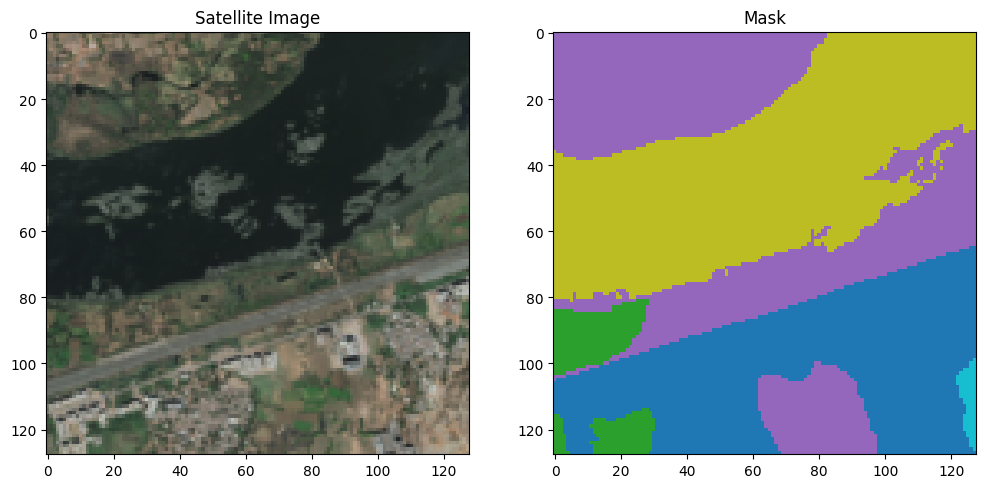

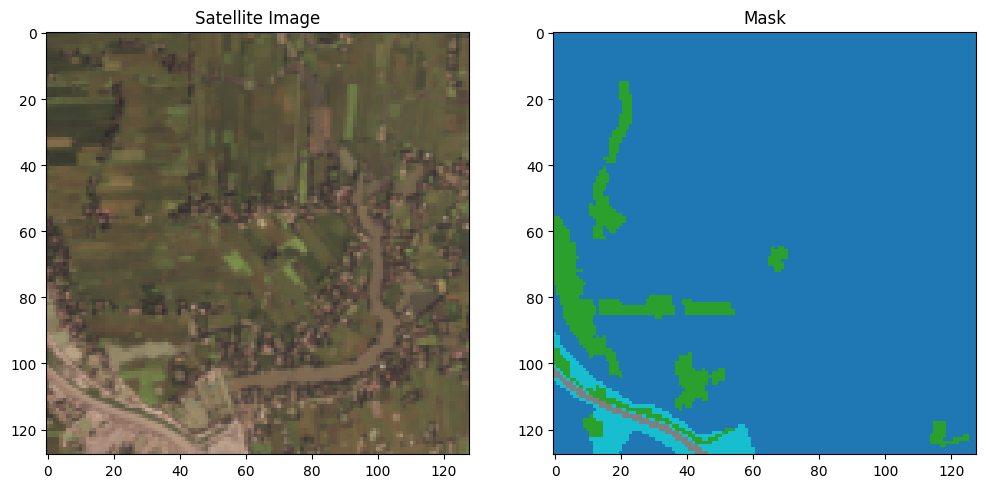

In [11]:
import matplotlib.pyplot as plt # Visualization
import torchvision.transforms.functional as TF

def visualize_samples(train_dataloader, num_samples=2):
    samples = iter(train_dataloader)
    for _ in range(num_samples):
        images, masks = next(samples)
        for i in range(images.size(0)):
            image = TF.to_pil_image(images[i])
            mask = masks[i].numpy()
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Satellite Image")
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='tab10')
            plt.title("Mask")
            plt.show()

visualize_samples(train_dataloader, num_samples=1)

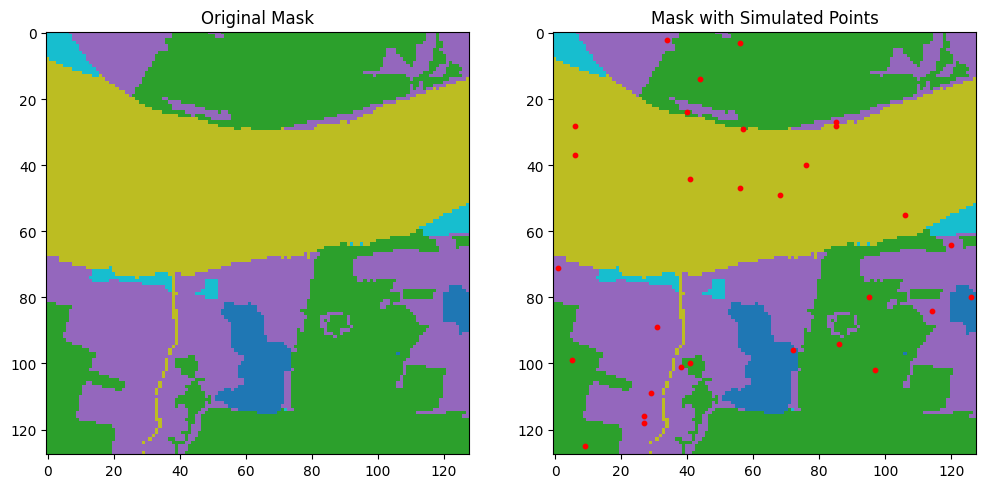

In [12]:
def simulate_point_labels(mask, num_points=30): # Simulation of Label Points
    point_mask = torch.zeros_like(mask)
    height, width = mask.shape[-2], mask.shape[-1]
    points = []
    for _ in range(num_points):
        x = torch.randint(0, height, (1,)).item()
        y = torch.randint(0, width, (1,)).item()
        point_mask[..., x, y] = mask[..., x, y]
        points.append((x, y))
    return point_mask, points

import matplotlib.pyplot as plt
import numpy as np

def simulate_point_labels(mask, num_points=30):
    point_mask = torch.zeros_like(mask)
    height, width = mask.shape[-2], mask.shape[-1]
    points = []
    for _ in range(num_points):
        x = torch.randint(0, height, (1,)).item()
        y = torch.randint(0, width, (1,)).item()
        point_mask[..., x, y] = mask[..., x, y]
        points.append((x, y))
    return point_mask, points


for images, masks in train_dataloader:
    simulated_point_labels, points = simulate_point_labels(masks[0])
    break

mask_np = masks[0].numpy()
simulated_points_np = simulated_point_labels.numpy()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(mask_np, cmap='tab10')
plt.title("Original Mask")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='tab10')
for point in points:
    plt.scatter(point[1], point[0], color='red', s=10)  # y is x coordinate, x is y coordinate
plt.title("Mask with Simulated Points")

plt.show()

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleUNet(nn.Module): # UNet Class
    def __init__(self, in_channels=3, out_channels=7):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = SimpleUNet().to(device)  # Move model to GPU if available
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = PartialCrossEntropyLoss()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)  # Move data to GPU if available
        point_labels, _ = simulate_point_labels(masks)
        outputs = model(images)
        loss = criterion(outputs, masks, point_labels)  # Call the loss function with arguments
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch+1} \nLoss: {loss.item()}")

print("---End---")


Epoch: 1 
Loss: 1.817992091178894
Epoch: 2 
Loss: 1.3289589881896973
Epoch: 3 
Loss: 1.570331335067749
Epoch: 4 
Loss: 1.3781428337097168
Epoch: 5 
Loss: 1.453048586845398
---End---


In [28]:
def partial_cross_entropy_loss_eval(predictions, targets, mask_labeled):
    predictions = predictions.to(device)
    targets = targets.to(device)
    mask_labeled = mask_labeled.to(device)

    criterion = nn.CrossEntropyLoss(reduction='none')
    crossloss = criterion(predictions, targets)
    masked_loss = crossloss * mask_labeled
    total_labeled_points = mask_labeled.sum()
    pce = masked_loss.sum() / total_labeled_points
    return pce

def evaluate_model(model, dataloader, criterion): # Evaluate Model
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            point_labels, _ = simulate_point_labels(masks)
            outputs = model(images)
            loss = criterion(outputs, masks, point_labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)
test_loss = evaluate_model(model, test_dataloader, partial_cross_entropy_loss_eval)

print(f'Test Loss: {test_loss}')

Test Loss: 1.56129068945661


In [38]:
# # Hypothesis 1:
'''Increasing the depth of the U-Net architecture will improve
# the model's performance in semantic segmentation tasks.
'''
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DeepUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7, depth=1):
        super(DeepUNet, self).__init__()
        self.depth = depth
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder
        channels = in_channels
        for i in range(depth):
            self.encoder.append(self._make_encoder_layer(channels, 64 * (2**i)))
            channels = 64 * (2**i)

        # Decoder
        for i in range(depth - 1, -1, -1):
            self.decoder.append(self._make_decoder_layer(64 * (2**i), 64 * (2**max(i-1, 0))))

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def _make_encoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def _make_decoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder
        encoder_outputs = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            encoder_outputs.append(x)

        # Decoder
        for i, decoder_layer in enumerate(self.decoder):
            x = decoder_layer(x)
            if i < len(self.decoder) - 1:
                x = torch.cat([x, encoder_outputs[-i-2]], dim=1)

        x = self.final_conv(x)
        x = self.sigmoid(x)
        return x

# Function to train and evaluate the model
def train_and_evaluate(model, train_dataloader, test_dataloader, num_epochs=2):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = PartialCrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in train_dataloader:
            images, masks = images.to(device), masks.to(device)
            point_labels, _ = simulate_point_labels(masks)
            outputs = model(images)
            loss = criterion(outputs, masks, point_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch: {epoch+1}, Train Loss: {total_loss/len(train_dataloader)}")

    test_loss = evaluate_model(model, test_dataloader, partial_cross_entropy_loss_eval)
    return test_loss

# Experiment with different depths
depths = [1, 2, 3, 4]
results = []

for depth in depths:
    print(f"Training model with depth {depth}")
    model = DeepUNet(depth=depth).to(device)
    test_loss = train_and_evaluate(model, train_dataloader, test_dataloader)
    results.append((depth, test_loss))
    print(f"Depth: {depth}, Test Loss: {test_loss}\n")

# Print final results
print("Final Results:")
for depth, loss in results:
    print(f"Depth: {depth}, Test Loss: {loss}")


In [39]:
# Hypothesis 2
'''Incorporating a multi-scale feature fusion module in the U-Net architecture will
improve the model's ability to capture both local and global context,
leading to better performance in semantic segmentation tasks.
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiScaleFeatureFusion(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleFeatureFusion, self).__init__()
        self.branch1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.ReLU(inplace=True)
        )
        self.branch2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(2),
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(4),
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(8),
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.ReLU(inplace=True)
        )
        self.fusion = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size = x.size()[2:]
        feat1 = nn.functional.interpolate(self.branch1(x), size=size, mode='bilinear', align_corners=True)
        feat2 = nn.functional.interpolate(self.branch2(x), size=size, mode='bilinear', align_corners=True)
        feat3 = nn.functional.interpolate(self.branch3(x), size=size, mode='bilinear', align_corners=True)
        feat4 = nn.functional.interpolate(self.branch4(x), size=size, mode='bilinear', align_corners=True)
        feat = torch.cat([feat1, feat2, feat3, feat4, x], dim=1)
        feat = self.fusion(feat)
        return feat

class UNetWithMultiScale(nn.Module):
    def __init__(self, in_channels=3, out_channels=7):
        super(UNetWithMultiScale, self).__init__()

        self.enc1 = self._make_encoder_layer(in_channels, 64) # ENCODER
        self.enc2 = self._make_encoder_layer(64, 128)
        self.enc3 = self._make_encoder_layer(128, 256)
        self.enc4 = self._make_encoder_layer(256, 512)

        self.msff = MultiScaleFeatureFusion(512)

        self.dec4 = self._make_decoder_layer(512, 256) # DECODER
        self.dec3 = self._make_decoder_layer(512, 128)
        self.dec2 = self._make_decoder_layer(256, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def _make_encoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

    def _make_decoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        e4 = self.msff(e4) # Fusion

        d4 = self.dec4(e4)
        d3 = self.dec3(torch.cat([d4, e3], dim=1))
        d2 = self.dec2(torch.cat([d3, e2], dim=1))
        d1 = self.dec1(torch.cat([d2, e1], dim=1))

        return d1

def train_and_evaluate(model, train_dataloader, test_dataloader, num_epochs=2):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in train_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch: {epoch+1}, Train Loss: {total_loss/len(train_dataloader)}")

    test_loss = evaluate_model(model, test_dataloader, criterion)
    return test_loss

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    return total_loss / len(dataloader)

models = {
    'UNet': SimpleUNet(),
    'UNet with Multi-Scale': UNetWithMultiScale()
}

results = []

for model_name, model in models.items():
    print(f"Training {model_name}")
    model = model.to(device)
    test_loss = train_and_evaluate(model, train_dataloader, test_dataloader)
    results.append((model_name, test_loss))
    print(f"{model_name} Test Loss: {test_loss}\n")

print("Final Results:")
for model_name, loss in results:
    print(f"{model_name} Test Loss: {loss}")

import matplotlib.pyplot as plt

model_names = [result[0] for result in results]
test_losses = [result[1] for result in results]

plt.figure(figsize=(10, 6))
plt.bar(model_names, test_losses)
plt.xlabel('Model Architecture')
plt.ylabel('Test Loss')
plt.title('Impact of Multi-Scale Feature Fusion on Model Performance')
plt.tight_layout()
plt.show()
